In [224]:
import torch 
import torch.nn as nn
import torchvision.transforms.functional as f



In [225]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Double Convolution Block constructor.

        Args:
        - in_channels (int): Number of input channels.
        - out_channels (int): Number of output channels.

        Returns:
        None
        """
        super(DoubleConv, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias = False ), 
            nn.BatchNorm2d(out_channels), 
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias = True), 
            nn.BatchNorm2d(out_channels), 
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        """
        Forward pass through the Double Convolution Block.

        Args:
        - x (Tensor): Input tensor.

        Returns:
        - output (Tensor): Output tensor.
        """
        return self.conv(x)

In [226]:
class UNet(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        """
        U-Net architecture constructor.

        Args:
        - in_channels (int): Number of input channels.
        - out_channels (int): Number of output channels.
        - features (list): List of feature channels for each downsample block.

        Returns:
        None
        """
        super(UNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = f.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return nn.ReLU()(self.final_conv(x))

In [227]:

def test():
    """
    Function to test the UNet model on sample input data.

    It creates a sample input tensor, initializes the UNet model, and generates predictions.
    The shape of the predictions is printed to the console.

    Usage:
    test()

    """
    x = torch.randn((1, 3, 320, 320))
    model = UNet(in_channels=3, out_channels=1)
    preds = model(x)
    print(preds.shape)
    #assert preds.shape == x.shape


test()
    

torch.Size([1, 1, 320, 320])


In [228]:
#From Here on we build using coursera based 

import os 
import sys 
import albumentations as A
dataset_path = os.path.join("Human-Segmentation-Dataset-master")
sys.path.append(dataset_path)

In [251]:
import torch
import cv2
import albumentations as A
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.utils.data import Dataset
IMAGE_SIZE = 224
BATCH_SIZE = 1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LR = 0.003
EPOCHS = 50

torch.cuda.empty_cache()

In [252]:

df = pd.read_csv(os.path.join(dataset_path, "train.csv"))
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [253]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

In [254]:
def get_train_augs():
  """
    Get data augmentation transformations for training data.

    Returns:
    A.Compose: A composition of data augmentation transformations including resizing,
                horizontal flip (50% probability), and vertical flip (50% probability).
    """
  return A.Compose([A.Resize(IMAGE_SIZE, IMAGE_SIZE), A.HorizontalFlip(0.5), A.VerticalFlip(0.5)], is_check_shapes=False)
def get_test_augs():
  """
    Get data augmentation transformations for testing data.

    Returns:
    A.Compose: A composition of data augmentation transformations including resizing.
    """
  return A.Compose([A.Resize(IMAGE_SIZE, IMAGE_SIZE)], is_check_shapes=False)

In [233]:
class SegmentationDataset(Dataset):
  """
  Custom dataset for segmentation tasks.

  Args:
  df (DataFrame): A DataFrame containing image and mask file paths.
  augmentations (callable, optional): A composition of image and mask augmentations. Default is None.

  Attributes:
  df (DataFrame): A DataFrame containing image and mask file paths.
  augmentations (callable, optional): A composition of image and mask augmentations.

  Methods:
  __len__(): Get the number of samples in the dataset.
  __getitem__(index): Retrieve an image-mask pair at the specified index.

  Returns:
  image (Tensor): Preprocessed image as a PyTorch Tensor.
  mask (Tensor): Preprocessed mask as a PyTorch Tensor.
  """
  def __init__(self, df, augmentations):
    """
    Initialize a SegmentationDataset.

    Args:
    df (DataFrame): A DataFrame containing image and mask file paths.
    augmentations (callable, optional): A composition of image and mask augmentations. Default is None.
    """
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    """
      Get the number of samples in the dataset.

      Returns:
      int: The number of samples in the dataset.
        """
    return len(self.df)

  def __getitem__(self, index):
    """
    Retrieve an image-mask pair at the specified index.

    Args:
    index (int): Index of the sample to retrieve.

    Returns:
    image (Tensor): Preprocessed image as a PyTorch Tensor.
    mask (Tensor): Preprocessed mask as a PyTorch Tensor.
    """
    row = self.df.iloc[index]
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data["image"]
      mask = data["mask"]

    # (h,w,c)-> (c,h, w)

    image = np.transpose(image, (2,0,1)).astype(np.float64)
    mask = np.transpose(mask, (2,0,1)).astype(np.float64)

    image = torch.Tensor(image) /255.0
    mask = torch.round(torch.Tensor(mask)/255.0)

    return image, mask


In [234]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_test_augs())

In [235]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


In [236]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle= True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)
print(f"total no. of batches in trainloader : {len(trainloader)}")
print(f"total no. of batches in validloader : {len(validloader)}")

total no. of batches in trainloader : 232
total no. of batches in validloader : 58


In [237]:
for image, mask in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([1, 3, 224, 224])
One batch mask shape : torch.Size([1, 1, 224, 224])


In [238]:
from torch import nn
from segmentation_models_pytorch.losses import DiceLoss

In [239]:
x = torch.randn((1, 3, 320, 320))
model = UNet(in_channels=3, out_channels=1)
preds = model(x)
print(preds.shape)
model = UNet(in_channels=3, out_channels=1)
model.to(DEVICE)

torch.Size([1, 1, 320, 320])


UNet(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [240]:
def composite_loss(logits, masks):
    loss1 = DiceLoss(mode="binary")(logits, masks)
    loss2 = nn.BCEWithLogitsLoss()(logits, masks)
    loss2 = nn.BCEWithLogitsLoss()(logits, masks)
    return loss1 + loss2

In [241]:
def train_fn(data_loader, model, optimizer):
  """
  Training function for a segmentation model.

  Args:
  data_loader (DataLoader): DataLoader for training data.
  model (nn.Module): Segmentation model.
  optimizer (optim.Optimizer): Optimization algorithm.

  Returns:
  float: Average training loss.
  """
  model.train()

  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()

    logits = model(images)
    loss = composite_loss(logits, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/ len(data_loader)

In [245]:
def eval_fn(data_loader, model):
  """
    Evaluation function for a segmentation model.

    Args:
    data_loader (DataLoader): DataLoader for evaluation data.
    model (nn.Module): Segmentation model.

    Returns:
    float: Average evaluation loss.
    """
  model.eval()

  total_loss = 0.0
  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)


      logits = model(images)
      loss = composite_loss(logits, masks)
      total_loss += loss.item()

    return total_loss/ len(data_loader)

In [246]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [255]:
best_valid_loss = np.Inf
for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)
  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pt")
    best_valid_loss = valid_loss
  print(f"Epoch : {i+1} Train_loss : {train_loss} Valid_loss : {valid_loss}")


100%|██████████| 58/58 [00:04<00:00, 11.74it/s]


Epoch : 1 Train_loss : 1.1774993225418289 Valid_loss : 1.3998057616168056


100%|██████████| 58/58 [00:04<00:00, 13.58it/s]


Epoch : 2 Train_loss : 1.175026958358699 Valid_loss : 1.3725783927687283


100%|██████████| 58/58 [00:02<00:00, 26.60it/s]


Epoch : 3 Train_loss : 1.1600730406313107 Valid_loss : 1.3980116268684124


100%|██████████| 58/58 [00:03<00:00, 14.68it/s]


Epoch : 4 Train_loss : 1.158564941893364 Valid_loss : 1.5373315852263878


100%|██████████| 58/58 [00:03<00:00, 14.68it/s]


Epoch : 5 Train_loss : 1.153479747217277 Valid_loss : 1.4088328850680385


100%|██████████| 58/58 [00:04<00:00, 14.01it/s]


Epoch : 6 Train_loss : 1.1470957578256213 Valid_loss : 1.3125081771406635


100%|██████████| 58/58 [00:03<00:00, 14.64it/s]


Epoch : 7 Train_loss : 1.1460456514152988 Valid_loss : 1.4222275542801823


100%|██████████| 58/58 [00:03<00:00, 14.61it/s]


Epoch : 8 Train_loss : 1.1402871084624324 Valid_loss : 1.4199833880210746


100%|██████████| 58/58 [00:03<00:00, 14.76it/s]


Epoch : 9 Train_loss : 1.131249096886865 Valid_loss : 1.3439970520035973


100%|██████████| 58/58 [00:04<00:00, 13.65it/s]


Epoch : 10 Train_loss : 1.1327387659714139 Valid_loss : 1.3821130024975743


100%|██████████| 58/58 [00:04<00:00, 12.19it/s]


Epoch : 11 Train_loss : 1.1271768816072365 Valid_loss : 1.375201368126376


100%|██████████| 58/58 [00:04<00:00, 11.90it/s]


Epoch : 12 Train_loss : 1.1147654138762375 Valid_loss : 1.3591215014457703


100%|██████████| 58/58 [00:01<00:00, 31.75it/s]


Epoch : 13 Train_loss : 1.118135543475891 Valid_loss : 1.4274180860354984


100%|██████████| 58/58 [00:03<00:00, 14.77it/s]


Epoch : 14 Train_loss : 1.106412199293745 Valid_loss : 1.38701989630173


100%|██████████| 58/58 [00:03<00:00, 14.84it/s]


Epoch : 15 Train_loss : 1.1046135209757706 Valid_loss : 1.339556044545667


100%|██████████| 58/58 [00:03<00:00, 14.80it/s]


Epoch : 16 Train_loss : 1.091565326370042 Valid_loss : 1.373775036170565


100%|██████████| 58/58 [00:05<00:00,  9.91it/s]


Epoch : 17 Train_loss : 1.0878481022242843 Valid_loss : 1.4984478118090794


100%|██████████| 58/58 [00:04<00:00, 13.33it/s]


Epoch : 18 Train_loss : 1.0791906948233474 Valid_loss : 1.4256983800181027


100%|██████████| 58/58 [00:04<00:00, 12.82it/s]


Epoch : 19 Train_loss : 1.0804857151775524 Valid_loss : 1.387019776064774


100%|██████████| 58/58 [00:04<00:00, 12.64it/s]


Epoch : 20 Train_loss : 1.0755659036081413 Valid_loss : 1.4259166131759513


100%|██████████| 58/58 [00:04<00:00, 13.57it/s]


Epoch : 21 Train_loss : 1.0619362588843395 Valid_loss : 1.3850293262251492


100%|██████████| 58/58 [00:04<00:00, 14.50it/s]


Epoch : 22 Train_loss : 1.0543421170321003 Valid_loss : 1.4304125082903896


100%|██████████| 58/58 [00:04<00:00, 12.96it/s]


Epoch : 23 Train_loss : 1.050935742670092 Valid_loss : 1.4398553340599454


100%|██████████| 58/58 [00:04<00:00, 13.00it/s]


Epoch : 24 Train_loss : 1.0561034544531642 Valid_loss : 1.4338647908177868


100%|██████████| 58/58 [00:04<00:00, 14.17it/s]


Epoch : 25 Train_loss : 1.0601341357005054 Valid_loss : 1.4484814939827755


100%|██████████| 58/58 [00:04<00:00, 13.66it/s]


Epoch : 26 Train_loss : 1.0386866451851253 Valid_loss : 1.4757969626064957


100%|██████████| 58/58 [00:04<00:00, 12.26it/s]


Epoch : 27 Train_loss : 1.040136334839566 Valid_loss : 1.363914771326657


100%|██████████| 58/58 [00:04<00:00, 11.78it/s]


Epoch : 28 Train_loss : 1.0386696847091461 Valid_loss : 1.4003985256984317


100%|██████████| 58/58 [00:03<00:00, 14.81it/s]


Epoch : 29 Train_loss : 1.0187280864037316 Valid_loss : 1.3933736908024754


100%|██████████| 58/58 [00:03<00:00, 14.84it/s]


Epoch : 30 Train_loss : 1.019680226799743 Valid_loss : 1.4945256833372444


100%|██████████| 58/58 [00:04<00:00, 14.48it/s]


Epoch : 31 Train_loss : 1.0206575120060608 Valid_loss : 1.4510360730105434


100%|██████████| 58/58 [00:04<00:00, 14.38it/s]


Epoch : 32 Train_loss : 1.0169185930541877 Valid_loss : 1.4180318805678138


100%|██████████| 58/58 [00:03<00:00, 14.75it/s]


Epoch : 33 Train_loss : 1.0098220910234699 Valid_loss : 1.4011386396556065


100%|██████████| 58/58 [00:03<00:00, 14.88it/s]


Epoch : 34 Train_loss : 1.0070801957927902 Valid_loss : 1.4036753085152855


100%|██████████| 58/58 [00:03<00:00, 14.76it/s]


Epoch : 35 Train_loss : 1.010721720112809 Valid_loss : 1.4428992322806655


100%|██████████| 58/58 [00:03<00:00, 14.88it/s]


Epoch : 36 Train_loss : 1.018954127513129 Valid_loss : 1.4568461806609714


100%|██████████| 58/58 [00:03<00:00, 14.86it/s]


Epoch : 37 Train_loss : 1.0006604858770454 Valid_loss : 1.4322624052393025


100%|██████████| 58/58 [00:03<00:00, 14.92it/s]


Epoch : 38 Train_loss : 0.9936197908787892 Valid_loss : 1.427328297804142


100%|██████████| 58/58 [00:03<00:00, 14.86it/s]


Epoch : 39 Train_loss : 0.9873112533883802 Valid_loss : 1.4947349079724015


100%|██████████| 58/58 [00:01<00:00, 30.98it/s]


Epoch : 40 Train_loss : 0.9841920602424391 Valid_loss : 1.3775345693374503


100%|██████████| 58/58 [00:03<00:00, 14.74it/s]


Epoch : 41 Train_loss : 0.9847260537589418 Valid_loss : 1.549456338430273


100%|██████████| 58/58 [00:03<00:00, 14.56it/s]


Epoch : 42 Train_loss : 1.0104080875372063 Valid_loss : 1.3911610923964401


100%|██████████| 58/58 [00:01<00:00, 31.25it/s]


Epoch : 43 Train_loss : 1.0159653395671269 Valid_loss : 1.4070013432667172


100%|██████████| 58/58 [00:03<00:00, 14.87it/s]


Epoch : 44 Train_loss : 0.9886578699124271 Valid_loss : 1.4300532967879855


100%|██████████| 58/58 [00:03<00:00, 14.93it/s]


Epoch : 45 Train_loss : 0.9799730722503416 Valid_loss : 1.5775658179973733


100%|██████████| 58/58 [00:03<00:00, 14.85it/s]


Epoch : 46 Train_loss : 0.9756211038550426 Valid_loss : 1.5242593062335048


100%|██████████| 58/58 [00:03<00:00, 14.73it/s]


Epoch : 47 Train_loss : 0.9763316321989586 Valid_loss : 1.5712076415275704


100%|██████████| 58/58 [00:04<00:00, 13.35it/s]


Epoch : 48 Train_loss : 0.9738180435680109 Valid_loss : 1.6565106994119183


100%|██████████| 58/58 [00:03<00:00, 14.86it/s]


Epoch : 49 Train_loss : 0.9794398501258472 Valid_loss : 1.6086296038380985


100%|██████████| 58/58 [00:03<00:00, 14.92it/s]

Epoch : 50 Train_loss : 0.9757758707835756 Valid_loss : 1.439326503153505


In [299]:
idx = 2
image, mask = validset[idx]
logits_mask = model(image.to(DEVICE).unsqueeze(0))

pred_mask = torch.sigmoid(logits_mask)

pred_mask = (pred_mask > 0.5)*1.0

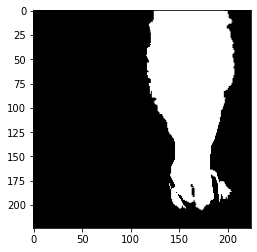

In [301]:
plt.imshow(torch.squeeze(torch.squeeze(pred_mask.detach().cpu())), cmap="gray")
plt.show()

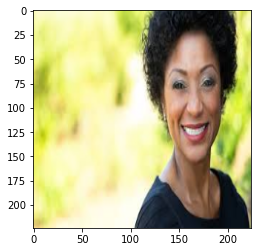

In [302]:
image = image.permute(1, 2, 0)

plt.imshow(torch.squeeze(torch.squeeze(image.detach().cpu())))
plt.show()